## Redshift Correction

In [1]:
import numpy as np
from astropy.io import fits
import glob
import lmfit
import matplotlib.pyplot as plt

In [2]:
balmer = [6564.61, 4862.68, 4341.68]#, 4102.89, 3971.2, 3890.12, 3835.397]

In [3]:
files = glob.glob('../data/*.fits')
filename = files[0]
with fits.open(filename) as f:
    flux = f[1].data['flux']
    lmbd = 10**f[1].data['loglam']
    ivar = f[1].data['ivar']

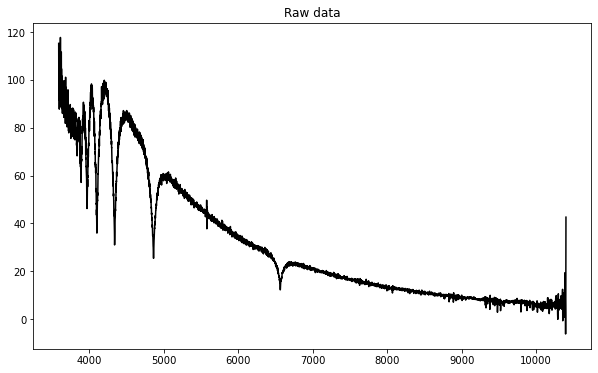

In [4]:
plt.figure(figsize=(10, 6))
plt.title('Raw data')
plt.plot(lmbd, flux, 'k')
plt.show()

To find the total redshift, the following procedure is performed on each of the Balmer series absorption lines:
1. Crop out a window surrounding the absorption line.
2. Ignore the middle half of the window, run a least-squares regression on a linear model across the remaining sections. This gives the expected continuum.  
3. Normalize the cropped window using the continuum.
4. Fit a pseudo-Voigt profile to the dip in the normalized spectrum. Note that here, the profile is subtracted from 1. The centroid of the profile is the empirical wavelength for the Balmer line.
5. Calculate and save the radial velocity needed to produce this redshift.

In [5]:
def lin_res(params, x, data, ivar):
    return (data-lin_model(x, params['m'], params['b']))*np.sqrt(ivar)

def lin_model(x, m, b):
    return m*x + b

In [6]:
def crop(arr, cdx, window_size):
    return arr[cdx-window_size//2:cdx+window_size//2]

def trim(arr, l, r, frac=True):
    if frac:
        ldx = round(len(arr)*l)
        rdx = round(len(arr)*r)
    else:
        ldx = l
        rdx = r
    return np.concatenate((arr[:ldx], arr[rdx:]))

In [7]:
def fit_cont(lmbd, flux, ivar):
    lmbd_corr = trim(lmbd, 0.25, 0.75)
    flux_corr = trim(flux, 0.25, 0.75)
    ivar_corr = trim(ivar, 0.25, 0.75)
    
    lpar = lmfit.Parameters()
    lpar.add('b', value=flux_corr[0], vary=True)
    lpar.add('m', value=0, vary=True)
    lfit = lmfit.minimize(lin_res, lpar, args=(lmbd_corr, flux_corr, ivar_corr))
    m = lfit.params['m'].value
    b = lfit.params['b'].value
    
    flux_cont = lin_model(lmbd_crop, m, b)
    flux_norm = flux_crop/flux_cont
    
    return flux_cont, flux_norm

def fit_dip(lmbd, flux, lprp):
    cnst = lmfit.models.ConstantModel()
    cnst.set_param_hint('c', value=1, vary=True)
    psvt = lmfit.models.PseudoVoigtModel()
    psvt.set_param_hint('center', value=lprp, vary=True)
    psvt.set_param_hint('amplitude', value=0.5, vary=True)
    psvt.set_param_hint('sigma', value=30, vary=True)
    dpar = psvt.make_params()
    dpar.update(cnst.make_params())
    
    dmodel = cnst-psvt
    dfit = dmodel.fit(flux, dpar, x=lmbd)
    flux_mdip = dmodel.eval(dfit.params, x=lmbd)
    mu = dfit.params['center'].value
    
    return mu, flux_mdip

In [8]:
def plot_cont(axis, lmbd, flux, ivar, cont, cutoffs):
    axis.set_title('Fitted continuum on data')
    axis.errorbar(lmbd, flux, yerr=1/ivar, fmt='.', label='data')
    axis.plot(lmbd, cont, label='continuum')
    axis.axvline(x=cutoffs[0], color='#DA0', label='linear fit cutoff')
    axis.axvline(x=cutoffs[1], color='#DA0')
    axis.legend()
    return axis

def plot_norm(axis, lmbd, norm, lprp, label):
    axis.set_title('Fitted dip on normalized data')
    axis.plot(lmbd, norm, '.', label='normalized')
    axis.axvline(x=lprp, color='k', label=label)
    axis.legend()
    return axis

def plot_dips(axis, lmbd, mdip, lobs, dlabel, llabel):
    axis.set_title('Fitted dip on normalized data')
    axis.plot(lmbd, mdip, label=dlabel)
    axis.axvline(x=lobs, color='r', label=llabel)
    axis.legend()
    return axis

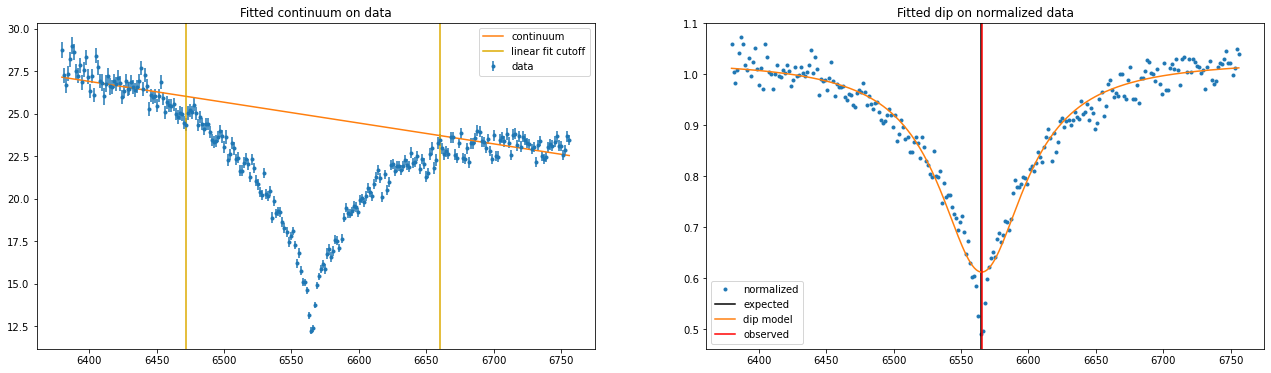

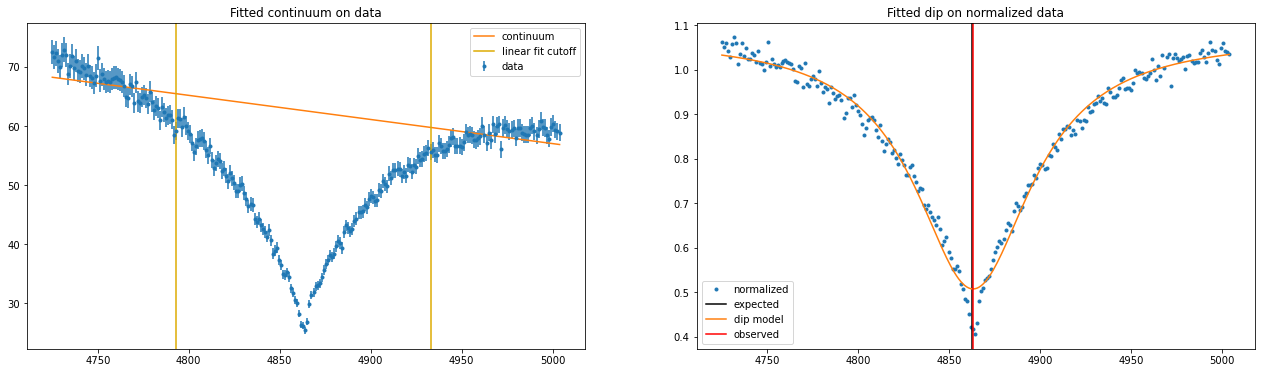

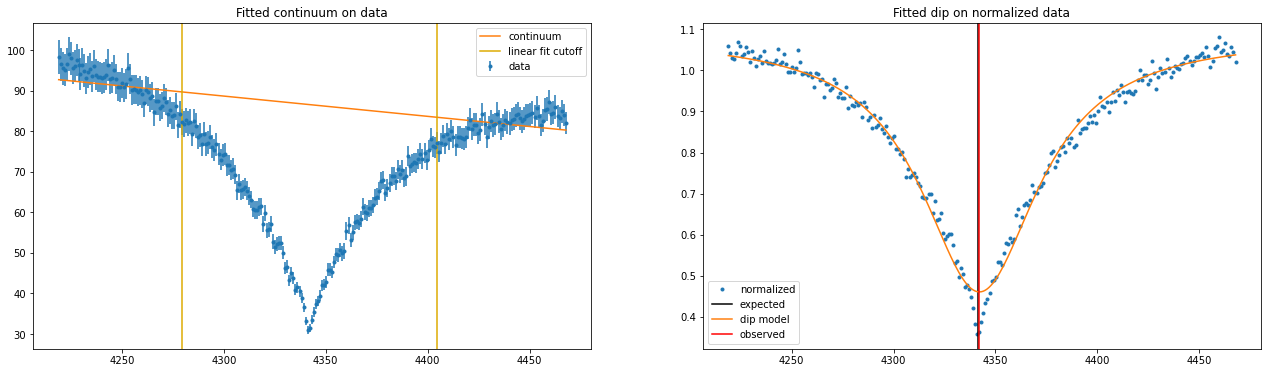

[33.92533555 22.2040232  33.38988046] 	km/s


In [9]:
window_size = 250
c = 3e8
vels = []

for lprp in balmer:
    cdx = np.searchsorted(lmbd, (lprp))
    lmbd_crop = crop(lmbd, cdx, window_size)
    flux_crop = crop(flux, cdx, window_size)
    ivar_crop = crop(ivar, cdx, window_size)
    
    # fit continuum (linear)
    flux_cont, flux_norm = fit_cont(lmbd_crop, flux_crop, ivar_crop)
    
    # fit dips (psuedo-voigt)
    mu, flux_mdip = fit_dip(lmbd_crop, flux_norm, lprp)
    
    # get doppler shift
    lobs = mu
    vels.append(lobs/lprp-1)
    
    # print results
    fig, axes = plt.subplots(1, 2, figsize=(22,6))
    
    axes[0] = plot_cont(axes[0], lmbd_crop, flux_crop, ivar_crop, flux_cont,
                        (lmbd_crop[window_size//4], lmbd_crop[3*window_size//4]))
    
    axes[1] = plot_norm(axes[1], lmbd_crop, flux_norm, lprp, 'expected')
    axes[1] = plot_dips(axes[1], lmbd_crop, flux_mdip, lobs, 'dip model', 'observed')
    
    plt.show()

vels = np.array(vels)*c
print(vels/1e3, '\tkm/s')

From the first three Balmer lines, take the mean of the velocities for the total radial velocity of the white dwarf. Note that the relative errors in the fit were incredibly small and using them for a weighted average produced a negligible effect.

Only three Balmer lines were used because the remaining absorption lines overlap one another, making it difficult to find an accurate continuum.

In [10]:
totv = np.mean(vels)
print(totv/1e3, 'km/s')
lmbd_rshf = lmbd / (1 + totv/c)

29.839746405313505 km/s


Below is the corrected spectrum, and a comparison with the raw spectrum.

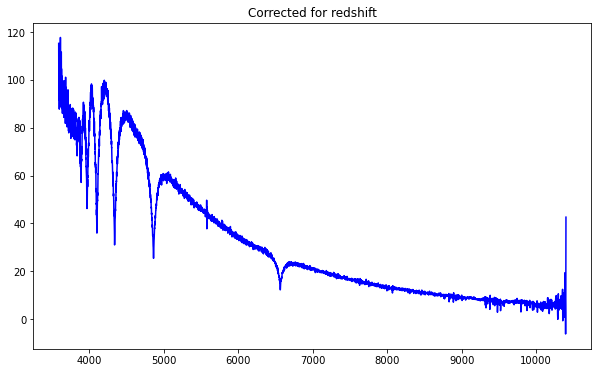

In [11]:
plt.figure(figsize=(10, 6))
plt.title('Corrected for redshift')
plt.plot(lmbd_rshf, flux, 'b')
plt.show()

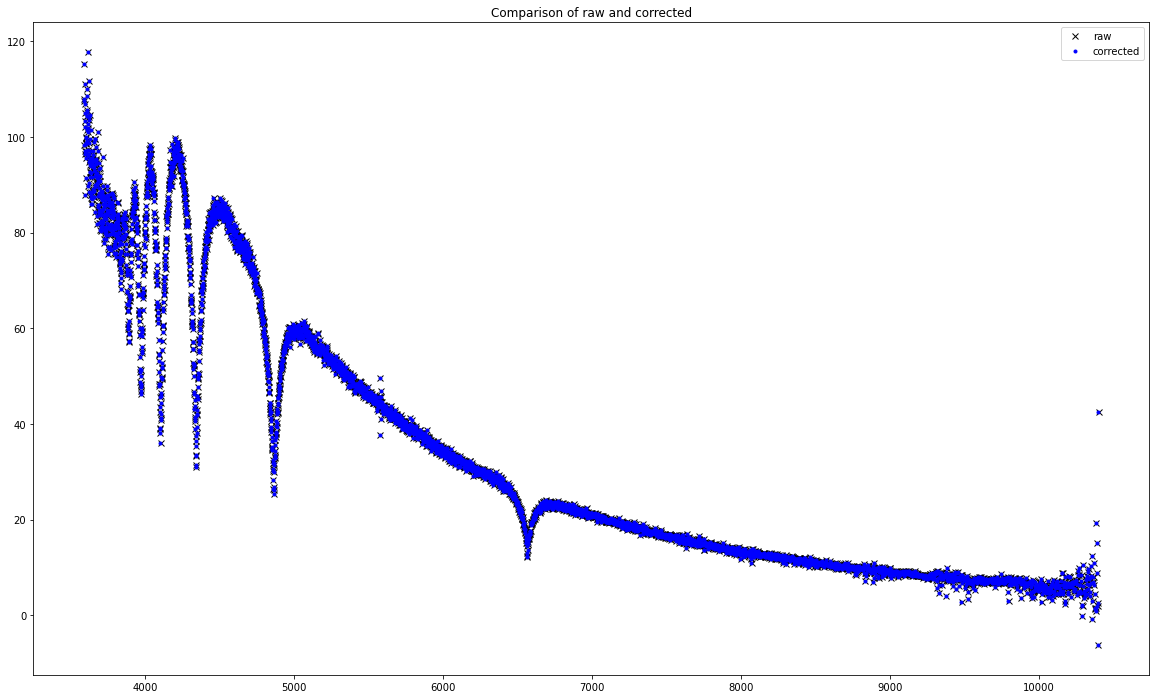

In [12]:
plt.figure(figsize=(20, 12))
plt.title('Comparison of raw and corrected')
plt.plot(lmbd, flux, 'kx', label='raw')
plt.plot(lmbd_rshf, flux, 'b.', label='corrected')
plt.legend()
plt.show()

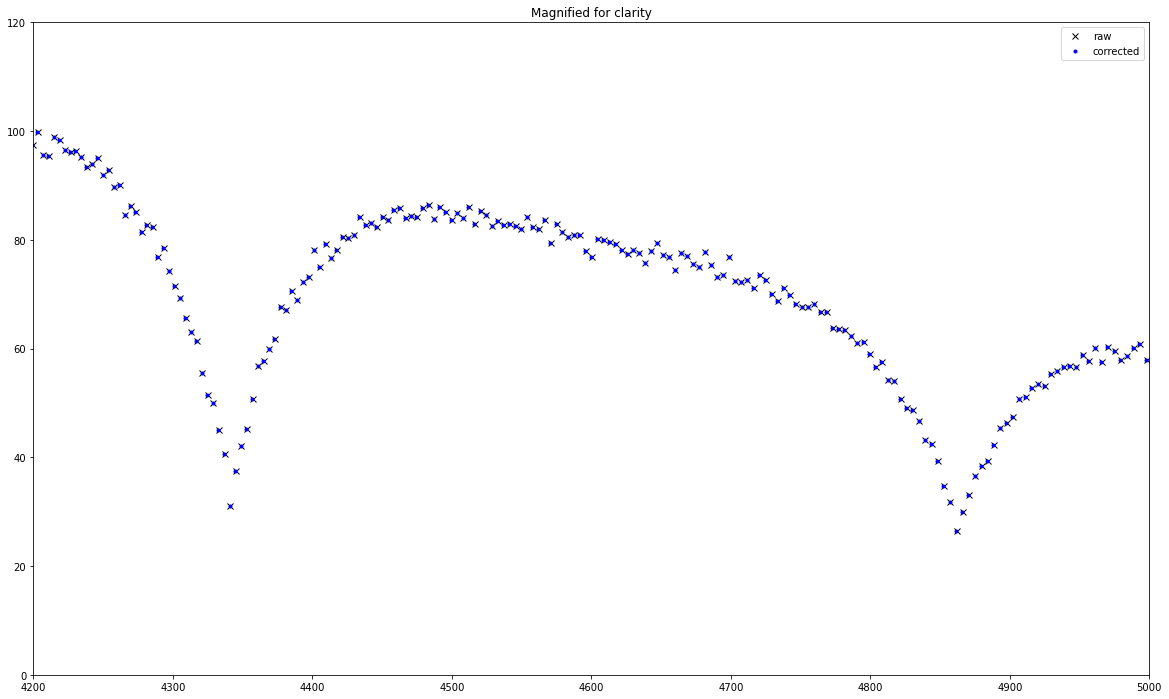

In [13]:
step = 4
lmbd_fltr = lmbd[::step]
lmbd_rshf_fltr = lmbd_rshf[::step]
flux_fltr = flux[::step]

plt.figure(figsize=(20, 12))
plt.title('Magnified for clarity')
plt.plot(lmbd_fltr, flux_fltr, 'kx', label='raw')
plt.plot(lmbd_rshf_fltr, flux_fltr, 'b.', label='corrected')
plt.xlim(4200, 5000)
plt.ylim(0, 120)
plt.legend()
plt.show()

### Checking results - refitting dip

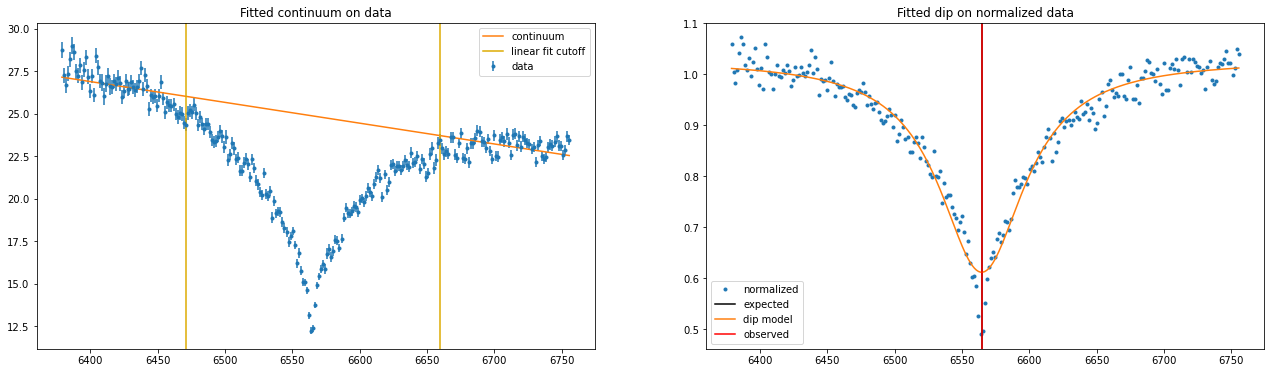

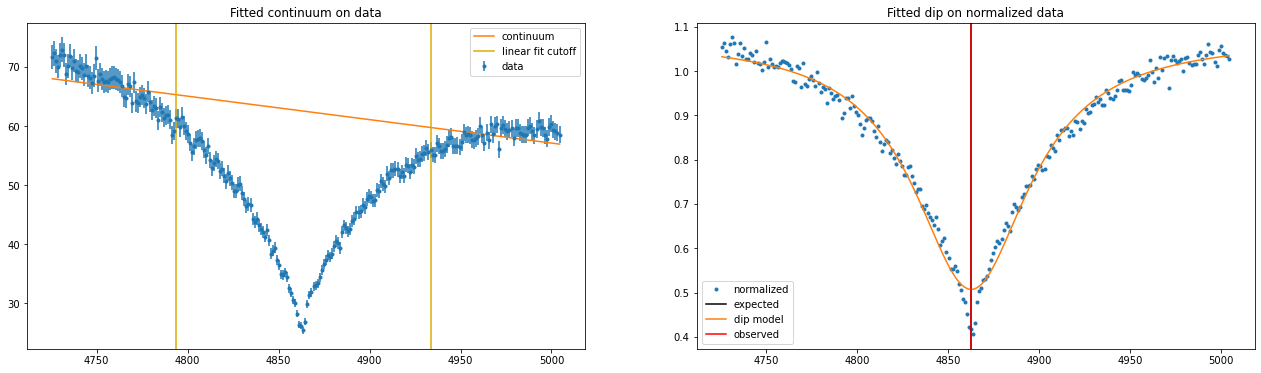

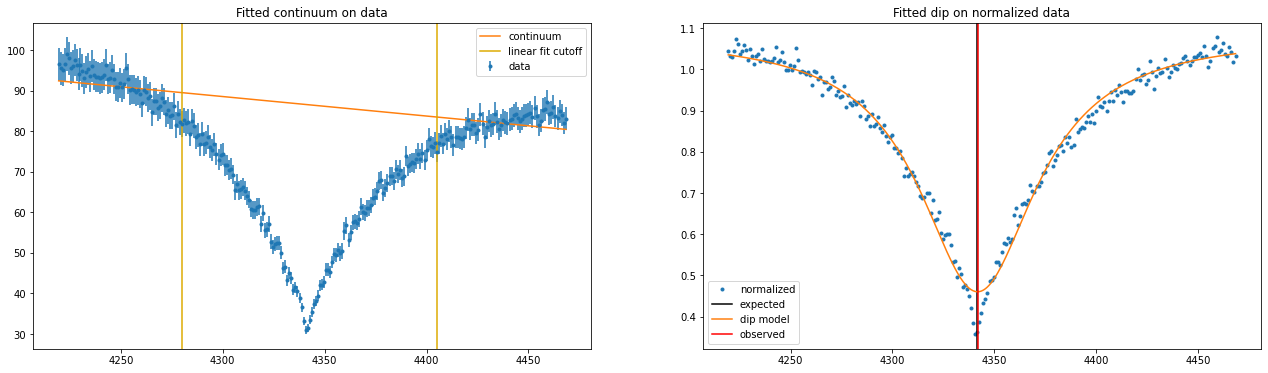

In [14]:
window_size = 250
c = 3e8
mus = []

for lprp in balmer:
    cdx = np.searchsorted(lmbd_rshf, (lprp))
    lmbd_crop = crop(lmbd_rshf, cdx, window_size)
    flux_crop = crop(flux, cdx, window_size)
    ivar_crop = crop(ivar, cdx, window_size)
    
    # fit continuum (linear)
    flux_cont, flux_norm = fit_cont(lmbd_crop, flux_crop, ivar_crop)
    
    # fit dips (psuedo-voigt)
    mu, flux_mdip = fit_dip(lmbd_crop, flux_norm, lprp)
    mus.append(mu)
    
    # print results
    fig, axes = plt.subplots(1, 2, figsize=(22,6))
    
    axes[0] = plot_cont(axes[0], lmbd_crop, flux_crop, ivar_crop, flux_cont,
                        (lmbd_crop[window_size//4], lmbd_crop[3*window_size//4]))
    
    axes[1] = plot_norm(axes[1], lmbd_crop, flux_norm, lprp, 'expected')
    axes[1] = plot_dips(axes[1], lmbd_crop, flux_mdip, mu, 'dip model', 'observed')
    
    plt.show()

In [15]:
mus = np.array(mus)
print('Fitted:\t', mus)
print('Actual:\t', balmer)

print('Diff:\t', mus-balmer)

Fitted:	 [6564.7003198  4862.65945149 4341.82457525]
Actual:	 [6564.61, 4862.68, 4341.68]
Diff:	 [ 0.0903198  -0.02054851  0.14457525]


Clearly, this method helps the process, but is not fully adequate; while the differences are smaller than before, they are still quite large.

## Iterative Method (H$\alpha$ line only)

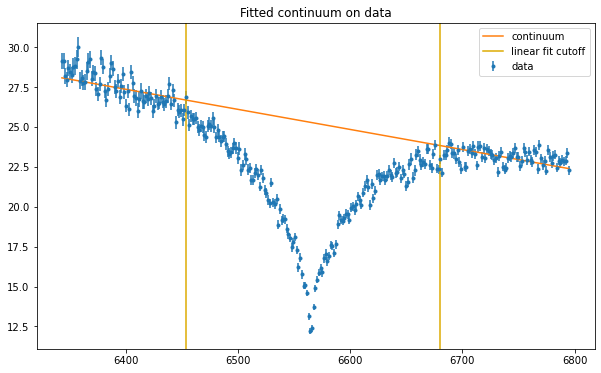

In [16]:
halpha = 6564.61 # Angstroms
window_cont = 300 # window size to determine continuum

# get continuum and normalized fluxes
cdx = np.searchsorted(lmbd, (halpha))
lmbd_crop = crop(lmbd, cdx, window_cont)
flux_crop = crop(flux, cdx, window_cont)
ivar_crop = crop(ivar, cdx, window_cont)

flux_cont, flux_norm = fit_cont(lmbd_crop, flux_crop, ivar_crop)

plt.figure(figsize=(10,6))
axes = plt.axes()
axes = plot_cont(axes, lmbd_crop, flux_crop, ivar_crop, flux_cont,
                 (lmbd_crop[window_cont//4], lmbd_crop[3*window_cont//4]))
plt.show()

In [17]:
# dip fit init (pseudo-Voigt)
cnst = lmfit.models.ConstantModel()
cnst.set_param_hint('c', value=1, vary=False)
psvt = lmfit.models.PseudoVoigtModel()
psvt.set_param_hint('center', value=halpha, vary=True)
psvt.set_param_hint('amplitude', value=0.5, vary=True)
psvt.set_param_hint('sigma', value=30, vary=True)
dpar = psvt.make_params()
dpar.update(cnst.make_params())
dmodel = cnst-psvt

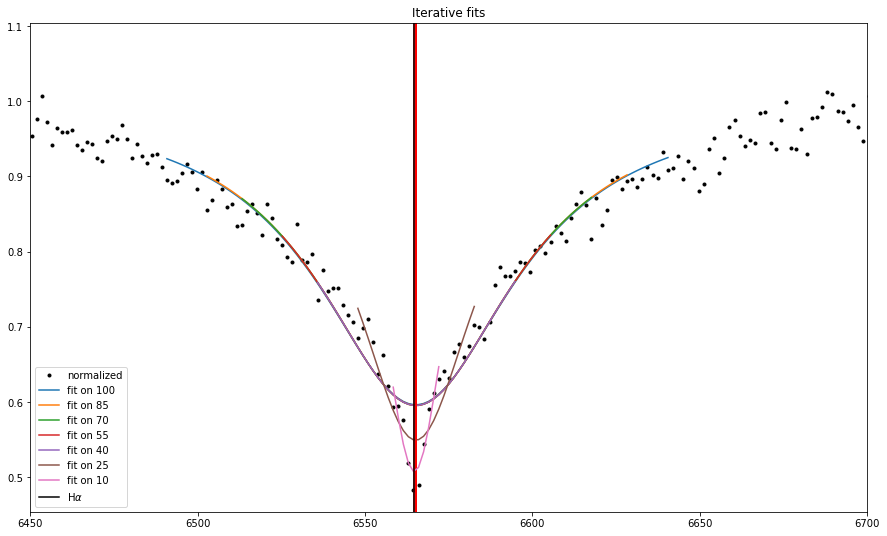

In [18]:
plt.figure(figsize=(15,9))
plt.title('Iterative fits')
plt.plot(lmbd_crop, flux_norm, 'k.', label='normalized')

window_iter = 100 # initial window width for redshift-fitting
window_step = 15 # iterative reduction in size
cdx = len(lmbd_crop)//2 # center of array
mus = []

# fit dip to iteratively smaller windows
while window_iter > 0:
    lmbd_fcrp = crop(lmbd_crop, cdx, window_iter) # fit crop
    flux_fcrp = crop(flux_norm, cdx, window_iter)
    
    dfit = dmodel.fit(flux_fcrp, dpar, x=lmbd_fcrp)
    dpar = dfit.params
    flux_mdip = dmodel.eval(dpar, x=lmbd_fcrp)
    mu = dfit.params['center'].value
    
    plt.plot(lmbd_fcrp, flux_mdip, label='fit on '+str(window_iter))
    plt.axvline(x=mu, color='r')
    
    mus.append(mu)
    window_iter -= window_step

plt.axvline(x=halpha, color='k', label=r'H$\alpha$')
plt.legend()
plt.xlim((6450,6700))
plt.show()

The red lines next to the black H$\alpha$ line are the fitted centroids.

As can be seen, almost all of the fits except for the last few are almost completely overlapping. The last two fits capture more of the "pointier" section of the graph.

Below, the fitted centroids are used to compute the redshift.

In [19]:
print(mus)
mu = np.mean(mus)
print('mu', str(mu), '\t', 'std', str(np.std(mus)))

vel = (mu/halpha-1)*c
print('Velocity:', vel/1e3, 'km/s')

lmbd_rshf = lmbd / (1 + vel/c)

[6565.19873314989, 6565.210113983771, 6565.210113983771, 6565.210113983771, 6565.210113983771, 6565.152688026211, 6564.739651663862]
mu 6565.133075539293 	 std 0.16178363193842354
Velocity: 23.90433883929788 km/s


The velocity found here, $23.8 km/s$, is very different from the previously found velocity, $29.8 km/s$.

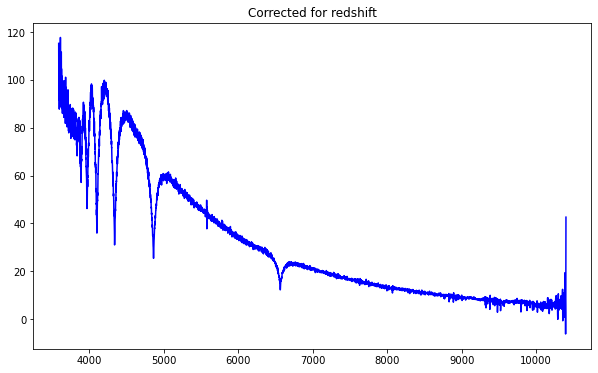

In [20]:
plt.figure(figsize=(10,6))
plt.title('Corrected for redshift')
plt.plot(lmbd_rshf, flux, 'b')
plt.show()

### Checking results - refitting dip

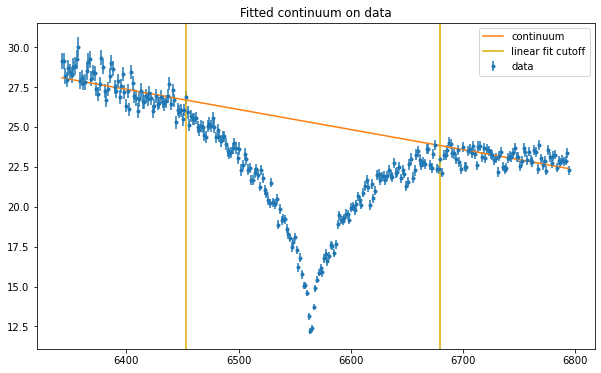

In [21]:
cdx = np.searchsorted(lmbd_rshf, (halpha))
lmbd_crop = crop(lmbd_rshf, cdx, window_cont)
flux_crop = crop(flux, cdx, window_cont)
ivar_crop = crop(ivar, cdx, window_cont)

flux_cont, flux_norm = fit_cont(lmbd_crop, flux_crop, ivar_crop)

plt.figure(figsize=(10,6))
axes = plt.axes()
axes = plot_cont(axes, lmbd_crop, flux_crop, ivar_crop, flux_cont,
                 (lmbd_crop[window_cont//4], lmbd_crop[3*window_cont//4]))
plt.show()

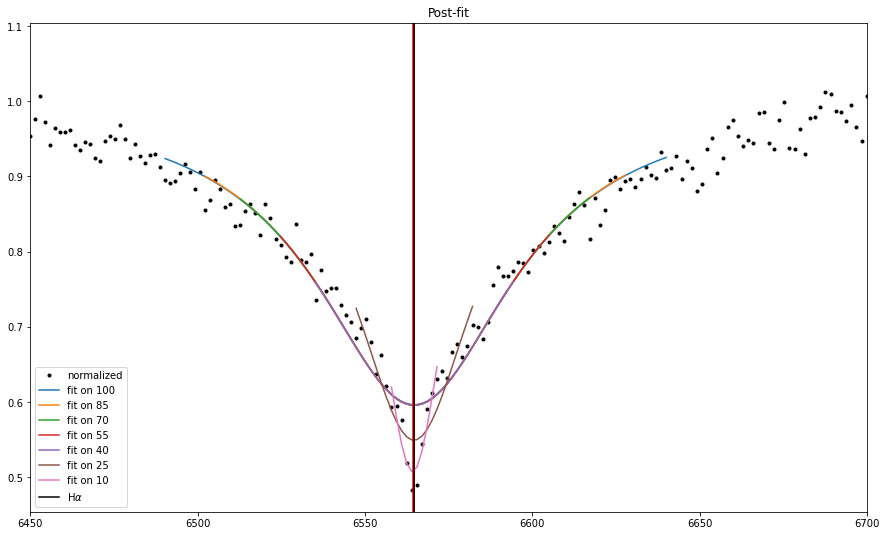

In [22]:
window_iter = 100
window_step = 15
cdx = len(lmbd_crop)//2
mus_post = []

plt.figure(figsize=(15,9))
plt.title('Post-fit')
plt.plot(lmbd_crop, flux_norm, 'k.', label='normalized')

while window_iter > 0:
    lmbd_fcrp = crop(lmbd_crop, cdx, window_iter)
    flux_fcrp = crop(flux_norm, cdx, window_iter)
    
    dfit = dmodel.fit(flux_fcrp, dpar, x=lmbd_fcrp)
    dpar = dfit.params
    flux_mdip = dmodel.eval(dpar, x=lmbd_fcrp)
    mu = dfit.params['center'].value
    
    plt.plot(lmbd_fcrp, flux_mdip, label='fit on '+str(window_iter))
    plt.axvline(x=mu, color='r')
    
    mus_post.append(mu)
    window_iter -= window_step

plt.axvline(x=halpha, color='k', label=r'H$\alpha$')
plt.legend()
plt.xlim((6450,6700))
plt.show()

In [23]:
print(mus_post)
mu = np.mean(mus_post)
print('mu:', mu, '\t', 'std:', np.std(mus_post))

[6564.6765392125335, 6564.684554761141, 6564.684554761141, 6564.684554761141, 6564.684554761141, 6564.629650105104, 6564.216841930255]
mu: 6564.60875004178 	 std: 0.16107211078401953


Clearly, the new $\mu$ is far closer to the expected H$\alpha$ line. Interestingly, the standard deviation of the new set did not go down, indicating that the main cause of the variation is from the included data points for the final fit.